# Modul 07 - Der Grover-Algorithmus

Eine Schulungsserie der Meetup-Gruppe **[Quantum Computing meets Business - Rhineland](https://www.meetup.com/de-DE/Quantum-Computing-meets-Business-Rhineland/)**

(Adapted from [qiskit-textbook](https://github.com/qiskit-community/qiskit-textbook))

In [1]:
run ./00-Inhalt_Tools.ipynb

In diesem Abschnitt stellen wir den Grover-Algorithmus vor und wie er verwendet werden kann, um unstrukturierte Suchprobleme zu lösen. Anschließend implementieren wir den Quantenalgorithmus mit Qiskit und führen ihn auf einem Simulator und auf Hardware aus.

## Contents

1. [Einführung](#introduction)
2. [Beispiel: 2 Qubits](#2qubits)    
   2.1 [Simulation](#2qubits-simulation)    
   2.2 [Hardware](#2qubits-device)    
3. [Beispiel: 3 Qubits](#3qubits)     
   3.1 [Simulation](#3qubits-simulation)    
   3.2 [Hardware](#3qubits-device)    
4. [Aufgaben](#problems)
5. [Ein Sudoku mit dem Grover-Algorithmus lösen](#sudoku)
5. [Verweise](#references)


## 1. Einführung <a id='introduction'></a>

Sie haben wahrscheinlich gehört, dass einer der vielen Vorteile, die ein Quantencomputer gegenüber einem klassischen Computer hat, seine überlegene Geschwindigkeit beim Durchsuchen von Datenbanken ist. Grovers Algorithmus demonstriert diese Fähigkeit. Dieser Algorithmus kann ein unstrukturiertes Suchproblem quadratisch beschleunigen, aber seine Verwendung geht darüber hinaus; Es kann als allgemeiner Trick oder Unterprogramm dienen, um quadratische Laufzeitverbesserungen für eine Vielzahl anderer Algorithmen zu erhalten. Dies wird als Amplitudenverstärkungstrick (Amplitude amplification) bezeichnet.

### Unstrukturierte Suche

Angenommen, Sie erhalten eine große Liste mit $N$-Elementen. Unter diesen Gegenständen gibt es einen Gegenstand mit einer einzigartigen Eigenschaft, den wir ausfindig machen möchten; wir nennen dies den Gewinner $w$. Stellen Sie sich jedes Element in der Liste als Kästchen in einer bestimmten Farbe vor. Angenommen, alle Elemente in der Liste sind grau, außer dem Gewinner $w$, der lila ist.

![image1](../assets/07-Grover-Algorithmus/grover_list.png)
<center> Copyright 2021, Qiskit Development Team. </center>

Um das violette Kästchen – das *markierte Element* – mit klassischer Berechnung zu finden, müsste man durchschnittlich $N/2$ dieser Kästchen nacheinander prüfen, und im schlimmsten Fall alle $N$ davon. Auf einem Quantencomputer hingegen können wir mit Grovers Amplitudenverstärkungstrick das markierte Objekt in etwa $\sqrt{N}$ Schritten finden. Eine quadratische Beschleunigung ist in der Tat eine erhebliche Zeitersparnis beim Auffinden markierter Elemente in langen Listen. Außerdem verwendet der Algorithmus nicht die interne Struktur der Liste, was sie *generisch* macht; deshalb liefert er für viele klassische Probleme sofort eine quadratische Quantenbeschleunigung.

### Erstellen eines Orakels

Für die Beispiele in dieser Session besteht unsere „Datenbank“ aus allen möglichen Rechenbasiszuständen, in denen sich unsere Qubits befinden können. Wenn wir beispielsweise 3 Qubits haben, besteht unsere Liste aus den Zuständen $|000\rangle, |001\rangle , \dots |111\rangle$ (also die Zustände $|0\rangle \rightarrow |7\rangle$).

Der Grover-Algorithmus verwendet ein "Orakel" (eine Subroutine), das eine negative Phase zu den Lösungszuständen hinzufügt. D.h. jeder Zustand $|x\rangle$ der Standardbasis (computational basis) wird zu:

$$
U_\omega|x\rangle = \bigg\{
\begin{aligned}
\phantom{-}|x\rangle \quad \text{falls} \; x \neq \omega \\
-|x\rangle \quad \text{falls} \; x = \omega \\
\end{aligned}
$$

Dieses Orakel ist eine diagonale Matrix, in der der Eintrag, der dem markierten Element entspricht, eine negative Phase hat. Wenn wir beispielsweise drei Qubits und $\omega = \text{101}$ haben, hat unser Orakel die folgende Matrix:

$$
U_\omega = 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{aligned}
\\
\\
\\
\\
\\
\\
\leftarrow \omega = \text{101}\\
\\
\\
\\
\end{aligned}
$$

Natürlich wissen wir normalerweise am Anfang nicht, wo sich der $-1$-Eintrag befindet. Wir wissen nur, dass das Orakel diese Form besitzen _muss_.  

Was Grovers Algorithmus so leistungsfähig macht, ist, wie einfach es ist, ein Problem in ein Orakel dieser Form umzuwandeln. Es gibt viele Rechenprobleme, bei denen es schwierig ist, eine Lösung zu _finden_, aber relativ einfach, eine Lösung zu _verifizieren_. Beispielsweise können wir eine Lösung für ein [Sudoku](https://en.wikipedia.org/wiki/Sudoku) leicht überprüfen, indem wir überprüfen, ob alle Regeln erfüllt sind. Wir müssen also nicht im Vorfeld wissen, welche Kandidaten markiert sind, wir brauchen nur ein paar einfache Kriterien mit denen wir sie überprüfen können!

Für das Probleme können wir eine Funktion $f$ erstellen, die eine vorgeschlagene Lösung $x$ nimmt und $f(x) = 0$ zurückgibt, wenn $x$ keine Lösung ist ($x \neq \omega$) und $ f(x) = 1$ für eine gültige Lösung ($x = \omega$). Unser Orakel kann dann wie folgt beschrieben werden:

$$
U_\omega|x\rangle = (-1)^{f(x)}|x\rangle
$$

und die Matrix des Orakels wird eine diagonale Matrix der Form sein:

$$
U_\omega = 
\begin{bmatrix}
(-1)^{f(0)} &   0         & \cdots &   0         \\
0           & (-1)^{f(1)} & \cdots &   0         \\
\vdots      &   0         & \ddots & \vdots      \\
0           &   0         & \cdots & (-1)^{f(2^n-1)} \\
\end{bmatrix}
$$


#### Schaltungsaufbau eines Grover-Orakels

Wenn wir unsere klassische Funktion $f(x)$ haben, können wir sie in eine umkehrbare Schaltung der Form umwandeln:
    
![image1b](../assets/07-Grover-Algorithmus/grover_boolean_oracle.svg)
<center> Copyright 2021, Qiskit Development Team. </center>    
    
Wenn wir das untere „Ausgabe“-Qubit in den Zustand $|{-}\rangle$ initialisieren, verwandelt der "Phasen-Kickback-Effekt" der negative Eigenwert von $|{-}\rangle$ in die negative Phase des  Grover-Orakels:

![image1c](../assets/07-Grover-Algorithmus/grover_phase_oracle.svg)
<center> Copyright 2021, Qiskit Development Team. </center>    

Wir ignorieren dann das Hilfs-Qubit ($|{-}\rangle$).
Richtig verstehen, können wir das erst, wenn wir uns den Phasen-Kickback genauer ansehen.

#### Der Phasen-Kickback-Effekt

Beim Kickback wird der Eigenwert, der durch ein Gate zu einem Qubit hinzugefügt wird, durch einen kontrollierten Vorgang in ein anderes Qubit „zurückgeworfen“. Wir haben zum Beispiel gesehen, dass die Ausführung eines X-Gatters an einem $|{-}\rangle$-Qubit diesem die Phase $-1$ verleiht:

$$
X|{-}\rangle = -|{-}\rangle
$$

Für die kontrollierte Version des $ X $ -Gatters (CNOT) bedeutet das: Wenn sich unser Kontroll-Qubit entweder in $|0\rangle$ oder $|1\rangle$ befindet, wirkt sich diese Phase auf den gesamten Zustand aus, es handelt sich jedoch um eine globale Phase und hat keine beobachtbaren Auswirkungen:

$$
\begin{aligned}
\text{CX}|{-}0\rangle = \text{CNOT}|{-}0\rangle & = |{-}\rangle \otimes |0\rangle \\
                        & = |{-}0\rangle \\
                        \quad & \\
\text{CX}|{-}1\rangle = \text{CNOT}|{-}1\rangle & = X|{-}\rangle \otimes |1\rangle \\
                        & = -|{-}\rangle \otimes |1\rangle \\
                        & = -|{-}1\rangle \\
\end{aligned}
$$

Der interessante Effekt entsteht, wenn unser Kontroll-Qubit überlagert ist. Die Komponente des Kontroll-Qubits, die in Richtung $|1\rangle$ liegt, wendet diesen Phasenfaktor auf das *entsprechende* Ziel-Qubit an. Dieser angewandte Phasenfaktor führt wiederum eine relative Phase in das Kontroll-Qubit ein:

$$
\begin{aligned}
\text{CNOT}|{-}{+}\rangle & = \tfrac{1}{\sqrt{2}}(\text{CNOT}|{-}0\rangle + \text{CNOT}|{-}1\rangle) \\
                           & = \tfrac{1}{\sqrt{2}}(|{-}0\rangle + X|{-}1\rangle) \\
                           & = \tfrac{1}{\sqrt{2}}(|{-}0\rangle -|{-}1\rangle) \\
\end{aligned}
$$

Dies kann dann als zwei separierbaren Qubit-Zustände geschrieben werden:

$$
\begin{aligned}
\text{CNOT}|{-}{+}\rangle & = |{-}\rangle \otimes \tfrac{1}{\sqrt{2}}(|{0}\rangle - |1\rangle )\\
                           & = |{-}{-}\rangle \\
\end{aligned}
$$

Wir sehen: Der X-Eigenwert $-1$ des Ausgabe-Qubits $|-\rangle$ wurde als relative / lokale Phase auf den ursprünglichen Zustand $|+\rangle$ des Kontroll-Qubits zurückgeworfen! 
Und genau die gleiche Strategie wenden wir an, um ein Grover-Orakel $ U_\omega $ zu implementieren: Wir müssen "nur" eine Funktion $f$ konstruieren, die ein CNOT-Gatter kontrolliert (genauso wie es der vorige symbolische Schaltkreis beschreibt). Wie man das macht, erfahren wir weiter unten.

Im nächsten Teil dieses Kapitels werden wir die Kernkonzepte des Algorithmus kennenlernen. Dabei wird deutlich werden, warum ein Orakel in der vorgestellten Form die echte Lösung nach und nach verstärkt und die falschen Lösungskandidaten nach und nach unterdrückt. Wir werden außerdem ein simples Beispielorakel erstellen, bei denen wir vorher $\omega$ kennen, und uns nicht darum kümmern, ob diese Orakel nützlich ist oder nicht. Am Ende des Kapitels behandeln wir ein kurzes Beispiel, in dem wir ein Orakel erstellen, um ein echtes Problem zu lösen (Sudoku).

### Amplitudenverstärkung (Amplitude Amplification)

Wie funktioniert der Algorithmus? Bevor wir uns die Liste der Lösungskandidaten ansehen, haben wir keine Ahnung, wo sich die echte Lösung befindet. Daher ist jede Vermutung seines Ortes so gut wie jede andere, die durch a ausgedrückt werden kann
gleichmäßige Superposition: $|s \rangle = \frac{1}{\sqrt{N}} \sum_{x = 0}^{N -1} | x
\rangle.$

Wenn wir an dieser Stelle in der Standardbasis $\{ |x \rangle \}$ messen würden, würde diese Superposition nach der Born-Regel mit der gleichen Wahrscheinlichkeit von $\frac{1}{N} = \frac{1}{2^n}$ in jeden der Basiszustände kollabieren. Unsere Chancen, den richtigen Wert $w$ zu erraten, sind daher $1$ in $2^n$, wie zu erwarten war. Daher müssten wir im Durchschnitt etwa $N/2 = 2^{n-1}$ Versuche machen, um das richtige Element zu erraten. Das ist die gleiche Situation, wie für den klassischen Algorithmus.

Geben Sie das Verfahren namens Amplitudenverstärkung ein, mit dem ein Quantencomputer diese Wahrscheinlichkeit erheblich erhöht. Dieses Verfahren dehnt (verstärkt) die Amplitude des markierten Elements interativ aus, wodurch die Amplitude der anderen Elemente verringert wird, sodass die Messung des Endzustands mit ziemlicher Sicherheit das richtige Element zurückgibt.

Dieser Algorithmus hat eine schöne geometrische Interpretation in Bezug auf zwei Reflexionen, die eine Drehung in einer zweidimensionalen Ebene erzeugen. Die einzigen zwei Sonderzustände, die wir berücksichtigen müssen, sind der Gewinner $| w \rangle$ und die gleichmäßige Superposition $| s\rangle$. Diese beiden Vektoren spannen eine zweidimensionale Ebene im Vektorraum $\mathbb{C}^N$ auf. Sie stehen nicht ganz senkrecht, weil $| w \rangle$ auch in der Überlagerung mit der Amplitude $\frac{1}{\sqrt{N}}$ vorkommt.
Wir können jedoch einen zusätzlichen Zustand $|s'\rangle$ einführen, der in der Spanne dieser beiden Vektoren liegt, die senkrecht zu $|w \rangle$ ist und wird aus $|s \rangle$ durch Entfernen von $|w \rangle$ erhalten und Neuskalierung.

**Schritt 1**: Der Vorgang der Amplitudenverstärkung beginnt in der gleichmäßigen Überlagerung $| s \rangle$, das sich leicht aus $| s\rangle=H^{\otimes n} | 0 \rangle^n$ konstruieren lässt.

![image2](../assets/07-Grover-Algorithmus/grover_step1.jpg)
<center> Copyright 2021, Qiskit Development Team. </center>


Die linke Grafik entspricht der zweidimensionalen Ebene, die von den senkrechten Vektoren $|w\rangle$ und $|s'\rangle$ aufgespannt wird, was es erlaubt, den Anfangszustand als $|s\rangle = \sin \theta | w \rangle + \cos\theta | s' \rangle$ auszudrücken, wobei $\theta = \arcsin \langle s | w \rangle = \arcsin \frac{1}{\sqrt{N}}$. Für große $ N $ bedeutet das, dass $ \theta $ in der Größenordnung von $ \frac{1}{\sqrt{N}} $ ist! Diese Eigenschaft ist für die Performance des Grover-Algorithmus entscheidend (s.u.). 
Die rechte Grafik ist ein Balkendiagramm der Amplituden des Zustands $| s\rangle$.

**Schritt 2**: Wir wenden die Orakelreflexion $U_f$ auf den Zustand $|s\rangle$ an.

![image3](../assets/07-Grover-Algorithmus/grover_step2.jpg)
<center> Copyright 2021, Qiskit Development Team. </center>

Geometrisch entspricht dies einer Spiegelung des Zustands $|s\rangle$ an $|s'\rangle$. Diese Transformation bedeutet, dass die Amplitude vor dem $|w\rangle$-Zustand negativ wird, was wiederum bedeutet, dass die durchschnittliche Amplitude (durch eine gestrichelte Linie angezeigt) verringert wurde.

**Schritt 3**: Wir wenden nun eine zusätzliche Reflexion ($U_s$) über den Zustand $|s\rangle$ an: $U_s = 2|s\rangle\langle s| - I $ . Diese Transformation bildet den Zustand auf $U_s U_f| s \rangle$ ab und vervollständigt die Transformation.

![image4](../assets/07-Grover-Algorithmus/grover_step3.jpg)
<center> Copyright 2021, Qiskit Development Team. </center>

Zwei Spiegelungen entsprechen immer einer Drehung. Die Transformation $U_s U_f$ dreht den Anfangszustand $|s\rangle$ näher zum Gewinner $|w\rangle$. Die Wirkung der Reflexion $U_s$ im Amplituden-Balkendiagramm kann als Reflexion über die mittlere Amplitude verstanden werden. Da die mittlere Amplitude durch die erste Reflexion abgesenkt wurde, hebt diese Transformation die negative Amplitude von $|w\rangle$ auf etwa das Dreifache ihres ursprünglichen Wertes an (also um etwa $\frac{3}{\sqrt{N}}$), während sie die anderen Amplituden absenkt. Wir gehen dann zu **Schritt 2**, um die Anwendung zu wiederholen. Dieser Vorgang wird mehrmals wiederholt, um den Gewinner zu ermitteln.

Nach $t$ Schritten befinden wir uns im Zustand $|\psi_t\rangle$ wo: $| \psi_t \rangle = (U_s U_f)^t | s \rangle.$

Wie oft müssen wir die Rotation anwenden? Es stellt sich heraus, dass ungefähr $\sqrt{N}$ Rotationen ausreichen: Wir haben gesehen, dass die Amplitude von $| w \rangle$ in $|\psi_t\rangle$ nach der ersten Grover-Iteration in der Größenordnung $\frac{1}{\sqrt{N}}$ angewachsen ist. D.h. auch der Drehwinkel $ \theta $ ist bei jeder Grover-Iteration von der Größenordnung $\frac{1}{\sqrt{N}}$. Das hatten wir bereits oben festgestellt. Wenn wir die Iteration also in der Größenordnung $ t \sim \sqrt{N} $ anwenden haben wir $|\psi_t\rangle$ maximal in die Richtung von $ | w \rangle$ gedreht. Eine Messung von $|\psi_t\rangle$ ergibt dann mit großer Wahrscheinlichkeit die Lösung $ w $. Die quadratische Beschleunigung des Grover-Algorithmus kommt also direkt aus der Hilbertraum-Eigenschaft der Quantenmechanik. Wir arbeiten hier in erster Linie mit Amplituden, für die der Satz des Pythagoras gilt. Erst durch die Messung am Ende ergeben sich daraus die Wahrscheinlichkeiten.

Für den Fall, dass es mehrere Lösungen gibt, $M$, kann gezeigt werden, dass ungefähr $\sqrt{(N/M)}$ Rotationen ausreichen.

![image5](../assets/07-Grover-Algorithmus/grover_circuit_high_level.png)
<center> Copyright 2021, Qiskit Development Team. </center>

Man kann übrigens formal beweisen, dass kein generischer Quanten-Suchalgorithmus mit einer Orakel-Strategie schneller ist, als der Grover-Algorithmus! So gesehen ist $ \sqrt{N} = 2^{n/2} $ auch eine Art Schranke für die maximale, generische Interferenzgeschwindigkeit der Quantenmechanik. 

## 2. Beispiel: 2 Qubits <a id='2qubits'></a>

Schauen wir uns zunächst den Fall des Grover-Algorithmus für $N=4$ an, der mit 2 Qubits realisiert wird. In diesem speziellen Fall ist nur <b>eine Rotation</b> erforderlich, um den Anfangszustand $|s\rangle$ zum Gewinner $|w\rangle$[3] zu rotieren:
<ol>
     <li>
         Nach der obigen Einführung haben wir im Fall $N=4$

$$\theta = \arcsin \frac{1}{2} = \frac{\pi}{6}.$$

</li>
<li>
         Nach $t$ Schritten haben wir $$(U_s U_\omega)^t | s\rangle=\sin\theta_t| \omega\rangle + \cos\theta_t | s' \rangle ,$$wobei $$\theta_t = (2t+1)\theta.$$

</li>
<li>
         Um $| \omega \rangle$ benötigen wir $\theta_t = \frac{\pi}{2}$, was mit oben eingefügtem $\theta=\frac{\pi}{6}$ zu $t=1$ führt. Das bedeutet, dass nach $t=1$ Rotation das gesuchte Element gefunden wird.
</li>
</ol>

Wir werden nun ein Beispiel mit einem bestimmten Orakel durchgehen.

#### Orakel für $\lvert \omega \rangle = \lvert 11 \rangle$
Betrachten wir den Fall $\lvert w \rangle = \lvert 11 \rangle$. Das Orakel $U_\omega$ verhält sich in diesem Fall wie folgt:

$$U_\omega | s \rangle = U_\omega \frac{1}{2}\left( |00\rangle + |01\rangle + |10\rangle + |11\rangle \right) = \frac{1}{2}\left( |00\rangle + |01\rangle + |10\rangle - |11\rangle \right).$$

oder:

$$
U_\omega = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1 \\
\end{bmatrix}
$$

die Sie vielleicht als das kontrollierte Z-Gate erkennen. In diesem Beispiel ist unser Orakel also einfach das kontrollierte Z-Gate:

![image6](../assets/07-Grover-Algorithmus/grover_circuit_2qbuits_oracle_11.svg)
<center> Copyright 2021, Qiskit Development Team. </center>

In diesem Beispiel gehen wir davon aus, den Zustand  $\lvert \omega \rangle = \lvert 11 \rangle$ im Vorfeld zu kennen. Natürlich wissen wir genau das normalerweise nicht. Stattdessen kennen wir Regeln, mit denen man jeden Lösungskandidaten verifizieren kann. Für unser simples Beispiel würde so eine Regel lauten

$$
  \text{Bit 1} \text{ UND } \text{Bit 2} = 1
$$

Unsere Grover-Schaltung prüft diese Regel für jeden Lösungskandidaten gleichzeitig. Die  Gleichung in diesem Beispiel ist so einfach, dass wir die Lösung sofort kennen. Aber stellen Sie sich ein ganzes Boolesches Gleichungssystem mit mehreren unbekannten Bits vor. Dieses "nSAT"-Problem ist erwiesener Maßen exponentiell schwierig zu lösen und der Grover-Algorithmus bietet hier zumindest eine quadratische Beschleunigung.  

#### Reflektion $U_s$
Um die Schaltung zu vervollständigen, müssen wir noch die zusätzliche Spiegelung $U_s = 2|s\rangle\langle s| - I$ implementieren. Da dies eine Reflexion über $|s\rangle$ ist, wollen wir jedem Zustand orthogonal zu $|s\rangle$ eine negative Phase hinzufügen.

Eine Möglichkeit, dies zu tun, besteht darin, die Operation zu verwenden, die den Zustand $|s\rangle \rightarrow |0\rangle$ transformiert, von dem wir bereits wissen, dass es das Hadamard-Gatter ist, das auf jedes Qubit angewendet wird:

$$H^{\otimes n}|s\rangle = |0\rangle$$

Dann wenden wir eine Schaltung an, die den Zuständen orthogonal zu $|0\rangle$ eine negative Phase hinzufügt:

$$U_0 \frac{1}{2}\left( \lvert 00 \rangle + \lvert 01 \rangle + \lvert 10 \rangle + \lvert 11 \rangle \right) = \frac{1}{2}\left( \lvert 00 \rangle - \lvert 01 \rangle - \lvert 10 \rangle - \lvert 11 \rangle \right)$$

d.h. die Vorzeichen jedes Zustands sind umgedreht, außer $\lvert 00 \rangle$. Eine Möglichkeit, $U_0$ zu implementieren, ist die folgende Schaltung:

![Circuit for reflection around |0>](../assets/07-Grover-Algorithmus/grover_circuit_2qbuits_reflection_0.svg)
<center> Copyright 2021, Qiskit Development Team. </center>

Zur Erinnerung:
$$
Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}
$$


Schließlich führen wir die Operation durch, die den Zustand $|0\rangle \rightarrow |s\rangle$ (wieder das H-Gatter) umwandelt:

$$H^{\otimes n}U_0 H^{\otimes n} = U_s$$

Die komplette Schaltung für $U_s$ sieht so aus:

![Circuit for reflection around |s>](../assets/07-Grover-Algorithmus/grover_circuit_2qbuits_reflection.svg)
<center> Copyright 2021, Qiskit Development Team. </center>


#### Vollständiger Schaltkreis für $\lvert w \rangle = |11\rangle$
Da im speziellen Fall von $N=4$ nur eine Drehung erforderlich ist, können wir die obigen Komponenten kombinieren, um die vollständige Schaltung für Grovers Algorithmus für den Fall $\lvert w \rangle = |11\rangle$ aufzubauen:

![image10](../assets/07-Grover-Algorithmus/grover_circuit_2qubits_full_11.svg)

### Kurzübung
1. Begründen Sie die Schaltung für die Reflektion $U_0$.
2. Was müsste man an dem vollständigen Schaltkreis ändern, um nach dem Zustand  $\lvert w \rangle = |00\rangle$ zu suchen?

### 2.1 Qiskit-Implementierung

Wir implementieren nun Grovers Algorithmus für den obigen Fall von 2 Qubits für $\lvert w \rangle = |11\rangle$.

In [2]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

Wir beginnen mit der Vorbereitung eines Quantenschaltkreises mit zwei Qubits:

In [3]:
n = 2
grover_circuit = QuantumCircuit(n)

Dann müssen wir nur noch die Befehle für die oben abgebildete Schaltung schreiben. Zuerst müssen wir den Zustand $|s\rangle$ initialisieren. Lassen Sie uns eine allgemeine Funktion (für eine beliebige Anzahl von Qubits) erstellen, damit wir sie später wieder verwenden können:

In [4]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [5]:
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

Wenden Sie das Orakel für $|w\rangle = |11\rangle$ an. Dieses Orakel ist spezifisch für 2 Qubits:

In [6]:
grover_circuit.cz(0,1) # Oracle
grover_circuit.draw()

┌───┐   
q_0: ┤ H ├─■─
     ├───┤ │ 
q_1: ┤ H ├─■─
     └───┘

<span id="general_diffuser"></span>Wir wollen jetzt den Diffusor ($U_s$) anwenden. Wie bei der Schaltung, die $|s\rangle$ initialisiert, erstellen wir einen allgemeinen Diffusor (für eine beliebige Anzahl von Qubits), damit wir ihn später in anderen Problemen verwenden können.

In [7]:
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw()

┌───┐   ┌───┐┌───┐   ┌───┐
q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     ├───┤ │ ├───┤├───┤ │ ├───┤
q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     └───┘   └───┘└───┘   └───┘

Dies ist unsere fertige Schaltung.

### 2.1.1 Experimentieren Sie mit Simulatoren <a id='2qubits-simulation'></a>

Lassen Sie uns die Schaltung in der Simulation ausführen. Zuerst können wir überprüfen, ob wir den richtigen Zustandsvektor haben:

In [8]:
sim = Aer.get_backend('aer_simulator')
# we need to make a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
grover_circuit_sim = grover_circuit.copy()
grover_circuit_sim.save_statevector()
result = sim.run(grover_circuit_sim).result()
statevec = result.get_statevector()

print(statevec)

Statevector([1.96261557e-16-3.69778549e-32j,
             2.22044605e-16+1.22464680e-16j,
             1.96261557e-16+1.22464680e-16j,
             1.00000000e+00-2.44929360e-16j],
            dims=(2, 2))


Wie erwartet ist die Amplitude jedes Zustands, der nicht $|11\rangle$ ist, 0, was bedeutet, dass wir eine 100%ige Chance haben, $|11\rangle$ zu messen:

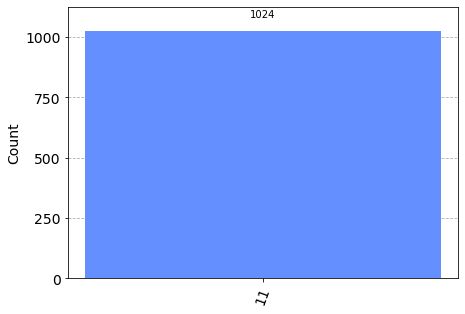

In [9]:
grover_circuit.measure_all()

aer_sim = Aer.get_backend('aer_simulator')
result = aer_sim.run(grover_circuit).result()
counts = result.get_counts()
plot_histogram(counts)

### 2.1.2 Experimentieren mit realen Geräten <a id='2qubits-device'></a>

Wir können die Schaltung mit einem echten Gerät wie unten ausführen.

In [10]:
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

Running on current least busy device:  ibmq_manila


In [11]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


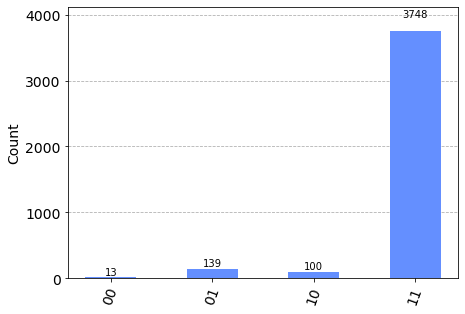

In [12]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

Wir bestätigen, dass in den meisten Fällen der Zustand $|11\rangle$ gemessen wird. Die anderen Ergebnisse sind auf Fehler in der Quantenberechnung zurückzuführen.

## 3. Beispiel: 3 Qubits <a id='3qubits'></a>

Wir gehen nun das Beispiel von Grovers Algorithmus für 3 Qubits mit zwei markierten Zuständen $\lvert101\rangle$ und $\lvert110\rangle$ durch, wobei wir der in Referenz [2] gefundenen Implementierung folgen. Der Quantenschaltkreis zur Lösung des Problems mit einem Phasenorakel lautet:

![image11](../assets/07-Grover-Algorithmus/grover_circuit_3qubits.png)
<center> Copyright 2021, Qiskit Development Team. </center>

<ol>
<li> 
Wenden Sie Hadamard-Gatter auf $3$-Qubits an, die mit $\lvert000\rangle$ initialisiert wurden, um eine einheitliche Überlagerung zu erzeugen:
  $$\lvert \psi_1 \rangle = \frac{1}{\sqrt{8}} \left( 
    \lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle + 
    \lvert100\rangle + \lvert101\rangle + \lvert110\rangle + \lvert111\rangle \right) $$
</li>

<li>
Markiere Zustände $\lvert101\rangle$ und $\lvert110\rangle$ mit einem Phasenorakel:
  $$\lvert \psi_2 \rangle = \frac{1}{\sqrt{8}} \left( 
    \lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle + 
    \lvert100\rangle - \lvert101\rangle - \lvert110\rangle + \lvert111\rangle \right) $$
</li>

<li>
Führen Sie die Reflexion um die mittlere Amplitude durch:
    
  <ol>
   <li> Wenden Sie Hadamard-Gatter auf die Qubits an
      $$\lvert \psi_{3a} \rangle = \frac{1}{2} \left( 
        \lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right) $$
   </li>
    
   <li> Wenden Sie X-Gatter auf die Qubits an
      $$\lvert \psi_{3b} \rangle = \frac{1}{2} \left( 
        -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle +\lvert111\rangle \right) $$
   </li>

   <li> Wenden Sie ein doppelt kontrolliertes Z-Gate zwischen den Qubits 1, 2 (Kontrollen) und 3 (Ziel) an
      $$\lvert \psi_{3c} \rangle = \frac{1}{2} \left( 
        -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right) $$
   </li>
   <li> Wenden Sie X-Gatter auf die Qubits an
      $$\lvert \psi_{3d} \rangle = \frac{1}{2} \left( 
        -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right) $$
   </li>
   <li> Wenden Sie Hadamard-Gatter auf die Qubits an
      $$\lvert \psi_{3e} \rangle = \frac{1}{\sqrt{2}} \left( 
        -\lvert101\rangle -\lvert110\rangle \right) $$
   </li>
  </ol>
</li>

<li>
  Messen Sie die $3$-Qubits, um die Zustände $\lvert101\rangle$ und abzurufen$\lvert110\rangle$
</li>
</ol>

Beachten Sie, dass wir, da es 2 Lösungen und 8 Möglichkeiten gibt, nur eine Iteration ausführen müssen (Schritte 2 und 3).

### 3.1 Qiskit-Implementierung<a id='3qubit-implementation'></a>

Wir implementieren nun den Grover-Algorithmus für das obige [Beispiel](#3qubits) für $3$-Qubits und suchen nach zwei markierten Zuständen $\lvert101\rangle$ und $\lvert110\rangle$. **Hinweis:** Denken Sie daran, dass Qiskit seine Qubits umgekehrt zu dieser Ressource ordnet, sodass der gezeichnete Schaltkreis um die Horizontale gedreht erscheint.

Wir erstellen ein Phasenorakel, das die Zustände $\lvert101\rangle$ und $\lvert110\rangle$ als Ergebnisse markiert (Schritt 1).

In [13]:
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U_w"

Im letzten Abschnitt haben wir einen spezifischen Diffusor für 2 Qubits verwendet, in der Zelle darunter erstellen wir einen allgemeinen Diffusor für eine beliebige Anzahl von Qubits.

<details>
<summary> Details: Erstellen eines allgemeinen Diffusors (zum Erweitern klicken)</summary>
    
Denken Sie daran, dass wir $U_s$ aus $U_0$ erstellen können:

$$ U_s = H^{\otimes n} U_0 H^{\otimes n} $$

Und ein mehrfach gesteuertes Z-Gate ($MCZ$) invertiert die Phase des Zustands $|11\dots 1\rangle$:

$$
MCZ = 
\begin{bmatrix}
 1 & 0 & 0 & \cdots & 0 \\
 0 & 1 & 0 & \cdots & 0 \\
 \vdots & \vdots & \vdots & \ddots & \vdots \\
 0 & 0 & 0 & \cdots & -1 \\
\end{bmatrix}
\begin{aligned}
\\
\\
\\
\leftarrow \text{Negative Phase hinzufügen zu} \; |11\dots 1\rangle\\
\end{aligned}
$$

Das Anwenden eines X-Gatters auf jedes Qubit führt die Transformation durch:

$$
\begin{aligned}
|00\dots 0\rangle & \rightarrow |11\dots 1\rangle\\
|11\dots 1\rangle & \rightarrow |00\dots 0\rangle
\end{aligned}
$$

Also:

$$ U_0 = - X^{\otimes n} (MCZ) X^{\otimes n} $$

Wenn wir diese Eigenschaften zusammen verwenden, können wir $U_s$ mit H-Gattern, X-Gattern und einem einzelnen mehrfach kontrollierten Z-Gatter erstellen:

$$ U_s = - H^{\otimes n} U_0 H^{\otimes n} = H^{\otimes n} X^{\otimes n} (MCZ) X^{\otimes n} H^{\otimes n} $$
    
Beachten Sie, dass wir die globale Phase von -1 ignorieren können.

</details>

In [14]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U_s"
    return U_s

Nun setzen wir die Teile zusammen, indem wir am Anfang der Schaltung eine gleichmäßige Überlagerung erzeugen und am Ende eine Messung vornehmen. Beachten Sie, dass wir nur eine Iteration ausführen müssen, da es 2 Lösungen und 8 Möglichkeiten gibt.

In [15]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌──────┐┌──────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0     ├┤0     ├─░─┤M├──────
        ├───┤│      ││      │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 U_w ├┤1 U_s ├─░──╫─┤M├───
        ├───┤│      ││      │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2     ├┤2     ├─░──╫──╫─┤M├
        └───┘└──────┘└──────┘ ░  ║  ║ └╥┘
meas: 3/═════════════════════════╩══╩══╩═
                                 0  1  2

### 3.1.1 Experimentieren Sie mit Simulatoren  <a id='3qubits-simulation'></a>

Wir können die obige Schaltung auf dem Simulator ausführen.

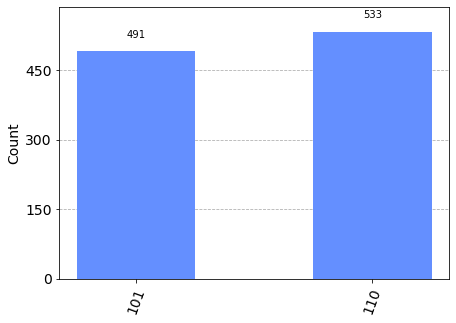

In [16]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
results = aer_sim.run(transpiled_grover_circuit).result()
counts = results.get_counts()
plot_histogram(counts)

Wie wir sehen können, entdeckt der Algorithmus unsere markierten Zustände $\lvert101\rangle$ und $\lvert110\rangle$.

### 3.1.2 Experimentieren mit realen Geräten <a id='3qubits-device'></a>

Wir können die Schaltung wie folgt auf dem realen Gerät ausführen.

In [17]:
backend = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_manila


In [18]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


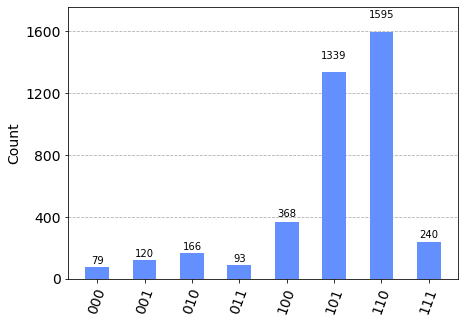

In [19]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

Wie wir (hoffentlich) sehen können, besteht eine höhere Wahrscheinlichkeit, $\lvert101\rangle$ und $\lvert110\rangle$ zu messen. Die anderen Ergebnisse sind auf Fehler in der Quantenberechnung zurückzuführen.

## 4. Probleme <a id='problems'></a>

Die Funktion „blackbox_grover_oracle(nqubits)“ gibt für eine Anzahl von Qubits („nqubits“) ein unbekanntes Orakel mit eindeutiger Lösung zurück. 

1. Passen Sie das letzte Beispiel an, indem Sie `blackbox_grover_oracle(4)` verwenden
    a. Wie viele Iterationen benötigen wir, um diese Lösung mit einer Wahrscheinlichkeit von > 90 % zu messen? Wieviele Iterationen würde der klassische Algorithmus benötigen?
    b. Verwenden Sie den Algorithmus von Grover, um diesen Lösungszustand zu finden.
    c. Was passiert, wenn wir mehr Iterationen anwenden, als wir in Aufgabe 1a oben berechnet haben? Warum?

2. Passen Sie Ihr letztes Listing an und erstellen Sie eine Funktion, `grover_solver(nqubits, iterations)`, die als Eingabe verwendet wird:
     - Die Anzahl von Qubits (`nqubits`)
     - Eine ganze Zahl von Iterationen (`iterations`)
    
    und gibt einen „QuantumCircuit“ zurück, der den Grover-Algorithmus auf dem „Orakel“-Gatter `blackbox_grover_oracle(nqubits)` mit „iterations“-Iterationen ausführt.
    
3. Geben Sie sich mit Hilfe dieser Funktion das Histogram nach diversen Grover-Iterationen aus. Überprüfen Sie Ihre Aussage von 1c.

## 5. Sudoku mit Grovers Algorithmus lösen <a id="sudoku"></a>

Die bisher in diesem Kapitel verwendeten Orakel wurden mit vorheriger Kenntnis ihrer Lösungen erstellt. Wir werden nun ein einfaches Problem mit dem Grover-Algorithmus lösen, für das wir die Lösung nicht unbedingt vorher kennen. Unser Problem ist ein 2×2 binäres Sudoku, das in unserem Fall zwei einfache Regeln hat:

- Keine Spalte darf denselben Wert zweimal enthalten
- Keine Zeile darf denselben Wert zweimal enthalten

Wenn wir jedem Quadrat in unserem Sudoku eine Variable zuweisen:

![2×2 binäres Sudoku, wobei jedes Feld einer anderen Variablen zugeordnet ist](../assets/07-Grover-Algorithmus/binary_sudoku.png)
<center> Copyright 2021, Qiskit Development Team. </center>

Wir möchten, dass unsere Schaltung eine Lösung für dieses Sudoku ausgibt.

Beachten Sie, dass dieser Ansatz, den Grover-Algorithmus zur Lösung dieses Problems zu verwenden, zwar nicht praktikabel ist (Sie können die Lösung wahrscheinlich in Ihrem Kopf finden!), der Zweck dieses Beispiels jedoch darin besteht, die Konvertierung klassischer [Entscheidungsprobleme](https:/ /en.wikipedia.org/wiki/Decision_problem) in Orakel für Grovers Algorithmus.

### 5.1 Das Problem in einen Schaltkreis verwandeln

Wir möchten ein Orakel erstellen, das uns bei der Lösung dieses Problems hilft, und wir beginnen mit der Erstellung einer Schaltung, die eine korrekte Lösung identifiziert. Ähnlich wie wir in unserem Kapitel "01-Uebersicht_Einfuehrung" einen klassischen Addierer mit Quantenschaltkreisen erstellt haben, müssen wir einfach eine _klassische_ Funktion auf a erstellen Quantenschaltung, die prüft, ob der Zustand unserer variablen Bits eine gültige Lösung ist.

Da wir beide Spalten und beide Zeilen überprüfen müssen, gibt es 4 Bedingungen, die wir überprüfen müssen:

```
v0 ≠ v1 # entlang der oberen Reihe prüfen
v2 ≠ v3 # entlang der unteren Reihe prüfen
v0 ≠ v2 # linke Spalte unten prüfen
v1 ≠ v3 # siehe rechte Spalte unten
```

Denken Sie daran, dass wir klassische (Rechenbasis-)Zustände vergleichen. Der Einfachheit halber können wir diese Reihe von Vergleichen in eine Liste von Klauseln kompilieren:

In [20]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

Wir werden den Wert jeder Variablen einem Bit in unserer Schaltung zuweisen. Um diese Klauseln rechnerisch zu überprüfen, verwenden wir das 'XOR'-Gatter (wir sind in der Einführung > Atome der Logik darauf gestoßen).

In [21]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

Überzeugen Sie sich selbst, dass das `output0`-Bit in der folgenden Schaltung nur gekippt wird, wenn `input0 ≠ input1`:

In [22]:
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw()

input_0: ──■───────
           │       
input_1: ──┼────■──
         ┌─┴─┐┌─┴─┐
 output: ┤ X ├┤ X ├
         └───┘└───┘

Diese Schaltung prüft, ob `input0 == input1` und speichert die Ausgabe in "output0". Um jede Klausel zu überprüfen, wiederholen wir diese Schaltung für jede Paarung in `clause_list` und speichern die Ausgabe in einem neuen Bit:

In [23]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw()

v_0: ──■─────────■───────────────────────────
       │         │                           
v_1: ──┼────■────┼─────────■─────────────────
       │    │    │         │                 
v_2: ──┼────┼────┼────■────┼─────────■───────
       │    │    │    │    │         │       
v_3: ──┼────┼────┼────┼────┼────■────┼────■──
     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │  
c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼──
     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │  
c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼──
               └───┘└───┘┌─┴─┐┌─┴─┐  │    │  
c_2: ────────────────────┤ X ├┤ X ├──┼────┼──
                         └───┘└───┘┌─┴─┐┌─┴─┐
c_3: ──────────────────────────────┤ X ├┤ X ├
                                   └───┘└───┘

Der Endzustand der Bits `c0, c1, c2, c3` wird nur dann alle `1` sein, wenn die Zuweisungen von `v0, v1, v2, v3` eine Lösung für das Sudoku sind. Um unsere Prüfschaltung zu vervollständigen, möchten wir, dass ein einzelnes Bit `1` ist, wenn (und nur wenn) alle Klauseln erfüllt sind. Auf diese Weise können wir nur ein Bit betrachten, um zu sehen, ob unsere Zuweisung eine Lösung ist. Wir können dies mit einem mehrfach gesteuerten Toffoli-Gatter tun:

In [24]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
qc.mct(clause_qubits, output_qubit)

qc.draw()

v_0: ──■─────────■────────────────────────────────
       │         │                                
v_1: ──┼────■────┼─────────■──────────────────────
       │    │    │         │                      
v_2: ──┼────┼────┼────■────┼─────────■────────────
       │    │    │    │    │         │            
v_3: ──┼────┼────┼────┼────┼────■────┼────■───────
     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       
c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──
     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  
c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■──
               └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │  
c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──
                         └───┘└───┘┌─┴─┐┌─┴─┐  │  
c_3: ──────────────────────────────┤ X ├┤ X ├──■──
                                   └───┘└───┘┌─┴─┐
out: ────────────────────────────────────────┤ X ├
                                             └───┘

Die obige Schaltung nimmt als Eingabe eine Anfangszuweisung der Bits `v0`, `v1`, `v2` und `v3`, und alle anderen Bits sollten auf `0` initialisiert werden. Nach dem Ausführen der Schaltung sagt uns der Zustand des `out0`-Bits, ob diese Zuordnung eine Lösung ist oder nicht; `out0 = 0` bedeutet die Zuweisung _ist_ keine Lösung und `out0 = 1` bedeutet die Zuweisung _ist_ eine Lösung.

**Wichtig:** Bevor Sie fortfahren, ist es wichtig, dass Sie diese Schaltung vollständig verstehen und davon überzeugt sind, dass sie wie im obigen Absatz beschrieben funktioniert.

### 5.2 Uncomputing und Vollendung des Orakels

Wir können diese Prüfschaltung nun mit [phase kickback](https://qiskit.org/textbook/ch-gates/phase-kickback.html) in ein Grover-Orakel verwandeln. Um es noch einmal zusammenzufassen, wir haben 3 Register:
- Ein Register, das unsere Sudoku-Variablen speichert (wir sagen $x = v_3, v_2, v_1, v_0$)
- Ein Register, das unsere Klauseln speichert (dies beginnt im Zustand $|0000\rangle$, den wir mit $|0\rangle$ abkürzen)
- Und ein Qubit ($|\text{out}_0\rangle$), das wir verwendet haben, um die Ausgabe unserer Prüfschaltung zu speichern.

Um ein Orakel zu erstellen, benötigen wir unsere Schaltung ($U_\omega$), um die Transformation durchzuführen:

$$
U_\omega|x\rangle|0\rangle|\text{out}_0\rangle = |x\rangle|0\rangle|\text{out}_0\oplus f(x)\rangle
$$

Wenn wir das `out0`-Qubit auf den Überlagerungszustand $|{-}\rangle$ setzen, haben wir:

$$
\begin{aligned}
U_\omega|x\rangle|0\rangle|{-}\rangle 
&= U_\omega|x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&= |x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|0\oplus f(x)\rangle - |1\oplus f(x)\rangle)
\end{aligned}
$$

Wenn $f(x) = 0$, dann haben wir den Zustand:

$$
\begin{aligned}
&= |x\rangle|0\rangle\otimes \tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&= |x\rangle|0\rangle|-\rangle\\
\end{aligned}
$$


(d.h. keine Änderung). Aber wenn $f(x) = 1$ (d. h. $x = \omega$), führen wir eine negative Phase in das $|{-}\rangle$-Qubit ein:

$$
\begin{aligned}
&= \phantom{-}|x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|1\rangle - |0\rangle)\\
&= \phantom{-}|x\rangle|0\rangle\otimes -\tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&= -|x\rangle|0\rangle|-\rangle\\
\end{aligned}
$$

Dies ist ein funktionierendes Orakel, das zwei Hilfsregister im Zustand verwendet $|0\rangle|{-}\rangle$:

$$
U_\omega|x\rangle|0\rangle|{-}\rangle = \Bigg\{
\begin{aligned}
\phantom{-}|x\rangle|0\rangle|-\rangle \quad \text{for} \; x \neq \omega \\
-|x\rangle|0\rangle|-\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

Um unsere Prüfschaltung an ein Grover-Orakel anzupassen, müssen wir sicherstellen, dass die Bits im zweiten Register (`c`) nach der Berechnung immer in den Zustand $|0000\rangle$ zurückkehren. Dazu wiederholen wir einfach den Teil der Schaltung, der die Klauseln berechnet, die `c0 = c1 = c2 = c3 = 0` garantieren, nachdem unsere Schaltung gelaufen ist. Wir nennen diesen Schritt _'uncomputation'_.

In [25]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw()

»
    v_0: ──■─────────■──────────────────────────────────■─────────■────────────»
           │         │                                  │         │            »
    v_1: ──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──»
           │    │    │         │                        │    │    │         │  »
    v_2: ──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼──»
           │    │    │    │    │         │              │    │    │    │    │  »
    v_3: ──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼──»
         ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │  »
    c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼──»
         └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │  »
    c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼──»
                   └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐»
    c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├»
                             └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘»
    c_3: ──────────────────────────────┤ X ├┤ X ├──■───────────────────────────»
                                       └───┘└───┘┌─┴─┐                         »
    out: ────────────────────────────────────────┤ X ├─────────────────────────»
                                                 └───┘                         »
cbits: 4/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                        
«    v_0: ───────────────
«                        
«    v_1: ───────────────
«                        
«    v_2: ───────■───────
«                │       
«    v_3: ──■────┼────■──
«           │    │    │  
«    c_0: ──┼────┼────┼──
«           │    │    │  
«    c_1: ──┼────┼────┼──
«         ┌─┴─┐  │    │  
«    c_2: ┤ X ├──┼────┼──
«         └───┘┌─┴─┐┌─┴─┐
«    c_3: ─────┤ X ├┤ X ├
«              └───┘└───┘
«    out: ───────────────
«                        
«cbits: 4/═══════════════
«

Zusammenfassend führt die obige Schaltung aus:

$$
U_\omega|x\rangle|0\rangle|\text{out}_0\rangle = \Bigg\{
\begin{aligned}
|x\rangle|0\rangle|\text{out}_0\rangle \quad \text{for} \; x \neq \omega \\
|x\rangle|0\rangle\otimes X|\text{out}_0\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

und wenn der Anfangszustand von $|\text{out}_0\rangle = |{-}\rangle$,:

$$
U_\omega|x\rangle|0\rangle|{-}\rangle = \Bigg\{
\begin{aligned}
\phantom{-}|x\rangle|0\rangle|-\rangle \quad \text{for} \; x \neq \omega \\
-|x\rangle|0\rangle|-\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

### 5.3 Der vollständige Algorithmus

Jetzt müssen Sie nur noch dieses Orakel in Grovers Algorithmus einfügen!

In [26]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1)

┌───┐               ░                                                                                       ░ ┌──────┐                                                                                      ░ ┌──────┐┌─┐         
    v_0: ─────────────┤ H ├───────────────░───■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0     ├──■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0     ├┤M├─────────
                      ├───┤               ░   │         │                                  │         │                            ░ │      │  │         │                                  │         │                            ░ │      │└╥┘┌─┐      
    v_1: ─────────────┤ H ├───────────────░───┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1     ├──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1     ├─╫─┤M├──────
                      ├───┤               ░   │    │    │         │                        │    │    │         │                  ░ │  U_s │  │    │    │         │                        │    │    │         │                  ░ │  U_s │ ║ └╥┘┌─┐   
    v_2: ─────────────┤ H ├───────────────░───┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2     ├──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2     ├─╫──╫─┤M├───
                      ├───┤               ░   │    │    │    │    │         │              │    │    │    │    │         │        ░ │      │  │    │    │    │    │         │              │    │    │    │    │         │        ░ │      │ ║  ║ └╥┘┌─┐
    v_3: ─────────────┤ H ├───────────────░───┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3     ├──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3     ├─╫──╫──╫─┤M├
                      └───┘               ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └──────┘┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └──────┘ ║  ║  ║ └╥┘
    c_0: ─────────────────────────────────░─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░─────────┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░──────────╫──╫──╫──╫─
                                          ░ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░         └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░          ║  ║  ║  ║ 
    c_1: ─────────────────────────────────░───────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░───────────────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░──────────╫──╫──╫──╫─
                                          ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░                   └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░          ║  ║  ║  ║ 
    c_2: ─────────────────────────────────░─────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░─────────────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░──────────╫──╫──╫──╫─
                                          ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐ ░                             └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐ ░          ║  ║  ║  ║ 
    c_3: ─────────────────────────────────░───────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├─░───────────────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├─░──────────╫──╫──╫──╫─
         ┌────────────────────────────

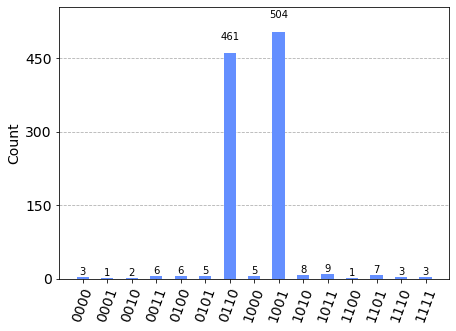

In [27]:
# Simulate and plot results
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
result = aer_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

Es gibt zwei Bitfolgen mit einer viel höheren Messwahrscheinlichkeit als alle anderen, nämlich `0110` und `1001`. Diese entsprechen den Aufgaben:
```
v0 = 0
v1 = 1
v2 = 1
v3 = 0
```
und
```
v0 = 1
v1 = 0
v2 = 0
v3 = 1
```
Das sind die beiden Lösungen für unser Sudoku! Das Ziel dieses Abschnitts ist es zu zeigen, wie wir Grover-Orakel aus realen Problemen erstellen können. Während dieses spezifische Problem trivial ist, kann der Prozess auf jedes Entscheidungsproblem angewendet werden (wobei ausreichend große Schaltungen zugelassen werden). Um es noch einmal zusammenzufassen, die Schritte sind:

1. Erstellen Sie einen umkehrbaren klassischen Schaltkreis, der eine korrekte Lösung identifiziert
2. Verwenden Sie Phasen-Kickback und Uncomputation, um diese Schaltung in ein Orakel zu verwandeln
3. Verwenden Sie Grovers Algorithmus, um dieses Orakel zu lösen

## 6. Verweise <a id='references'></a>

1. L. K. Grover (1996), "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (STOC 1996), [doi:10.1145/237814.237866](http://doi.acm.org/10.1145/237814.237866), [arXiv:quant-ph/9605043](https://arxiv.org/abs/quant-ph/9605043)
2. C. Figgatt, D. Maslov, K. A. Landsman, N. M. Linke, S. Debnath & C. Monroe (2017), "Complete 3-Qubit Grover search on a programmable quantum computer", Nature Communications, Vol 8, Art 1918, [doi:10.1038/s41467-017-01904-7](https://doi.org/10.1038/s41467-017-01904-7), [arXiv:1703.10535 ](https://arxiv.org/abs/1703.10535)
3. I. Chuang & M. Nielsen, "Quantum Computation and Quantum Information", Cambridge: Cambridge University Press, 2000.

In [28]:
import qiskit.tools.jupyter
%qiskit_version_table